In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('ICICIBANK.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,25.418180,25.818180,24.818180,25.127272,18.183353,2047540
2002-07-02,25.454544,27.636362,25.236362,26.745455,19.354351,5546354
2002-07-03,26.727272,28.181818,26.645454,28.090908,20.327986,5745267
2002-07-04,28.181818,28.799999,27.036364,27.390909,19.821428,3896601
2002-07-05,27.090908,27.863636,26.945454,27.672728,20.025368,3261038


In [5]:
# to check dates in index
df.index

DatetimeIndex(['2002-07-01', '2002-07-02', '2002-07-03', '2002-07-04',
               '2002-07-05', '2002-07-08', '2002-07-09', '2002-07-10',
               '2002-07-11', '2002-07-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=5216, freq=None)

In [6]:
df.shape

(5216, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,924.400024,935.549988,920.700012,925.750000,925.750000,27291569
2023-06-23,926.049988,931.900024,919.000000,923.500000,923.500000,8767733
2023-06-26,927.099976,931.799988,923.200012,927.450012,927.450012,11749040
2023-06-27,930.000000,939.950012,922.200012,936.099976,936.099976,13422726
2023-06-30,940.500000,942.200012,930.650024,934.599976,934.599976,13841095


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5216 entries, 2002-07-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5216 non-null   float64
 1   High       5216 non-null   float64
 2   Low        5216 non-null   float64
 3   Close      5216 non-null   float64
 4   Adj Close  5216 non-null   float64
 5   Volume     5216 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 285.2 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

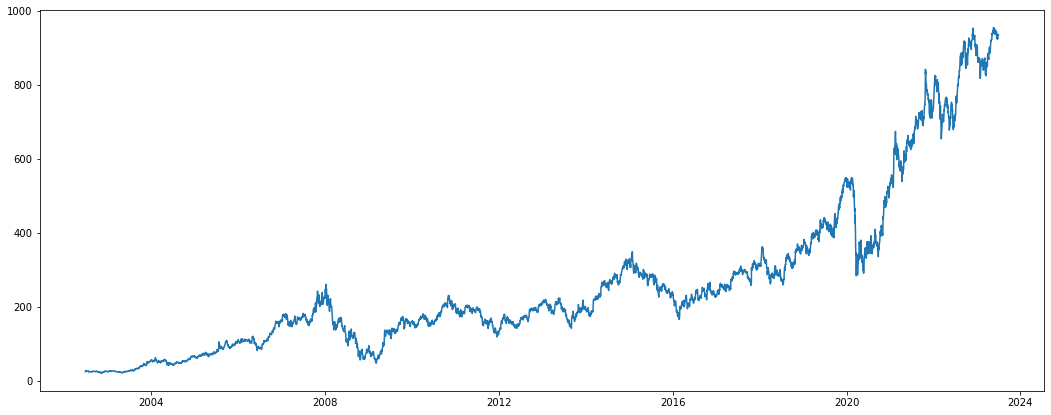

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  25.418180465698242
Ending price:  934.5999755859375


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  2002-07-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
2002-07-01,25.418180,25.127272
2002-07-02,25.454544,26.745455
2002-07-03,26.727272,28.090908
2002-07-04,28.181818,27.390909
2002-07-05,27.090908,27.672728


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00538137],
       [0.00711352],
       [0.00855374],
       ...,
       [0.97125886],
       [0.98051808],
       [0.97891243]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(3651, 1565)

In [21]:
train_data

array([[0.00538137],
       [0.00711352],
       [0.00855374],
       ...,
       [0.25533757],
       [0.24983944],
       [0.24740662]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[0.00538137, 0.00711352, 0.00855374, ..., 0.00604309, 0.00568303,
        0.0052062 ],
       [0.00711352, 0.00855374, 0.00780444, ..., 0.00568303, 0.0052062 ,
        0.00608201],
       [0.00855374, 0.00780444, 0.00810611, ..., 0.0052062 , 0.00608201,
        0.00533271],
       ...,
       [0.22872267, 0.23144742, 0.24317354, ..., 0.2538779 , 0.25324537,
        0.25562951],
       [0.23144742, 0.24317354, 0.24200581, ..., 0.25324537, 0.25562951,
        0.25694322],
       [0.24317354, 0.24200581, 0.24020553, ..., 0.25562951, 0.25694322,
        0.25533757]])

In [25]:
y_train

array([0.00608201, 0.00533271, 0.00584847, ..., 0.25694322, 0.25533757,
       0.24983944])

In [26]:
X_test

array([[0.25008271, 0.24964481, 0.24701738, ..., 0.24429263, 0.24803916,
        0.25309938],
       [0.24964481, 0.24701738, 0.24779588, ..., 0.24803916, 0.25309938,
        0.25227224],
       [0.24701738, 0.24779588, 0.24706604, ..., 0.25309938, 0.25227224,
        0.2478932 ],
       ...,
       [0.99614646, 0.99341687, 0.99534364, ..., 0.969225  , 0.96831516,
        0.9694391 ],
       [0.99341687, 0.99534364, 0.9944873 , ..., 0.96831516, 0.9694391 ,
        0.96703063],
       [0.99534364, 0.9944873 , 0.98051808, ..., 0.9694391 , 0.96703063,
        0.97125886]])

In [27]:
print(X_train.shape) 

(3630, 20)


In [28]:
print(y_train.shape)

(3630,)


In [29]:
print(X_test.shape)

(1544, 20)


In [30]:
print(ytest.shape)

(1544,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(3630, 20, 1)

In [33]:
X_train

array([[[0.00538137],
        [0.00711352],
        [0.00855374],
        ...,
        [0.00604309],
        [0.00568303],
        [0.0052062 ]],

       [[0.00711352],
        [0.00855374],
        [0.00780444],
        ...,
        [0.00568303],
        [0.0052062 ],
        [0.00608201]],

       [[0.00855374],
        [0.00780444],
        [0.00810611],
        ...,
        [0.0052062 ],
        [0.00608201],
        [0.00533271]],

       ...,

       [[0.22872267],
        [0.23144742],
        [0.24317354],
        ...,
        [0.2538779 ],
        [0.25324537],
        [0.25562951]],

       [[0.23144742],
        [0.24317354],
        [0.24200581],
        ...,
        [0.25324537],
        [0.25562951],
        [0.25694322]],

       [[0.24317354],
        [0.24200581],
        [0.24020553],
        ...,
        [0.25562951],
        [0.25694322],
        [0.25533757]]])

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
114/114 [==============================] - 5s 19ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 2/100
114/114 [==============================] - 2s 15ms/step - loss: 2.8278e-04 - val_loss: 9.4957e-04
Epoch 3/100
114/114 [==============================] - 2s 15ms/step - loss: 2.1456e-04 - val_loss: 4.2004e-04
Epoch 4/100
114/114 [==============================] - 2s 14ms/step - loss: 2.1092e-04 - val_loss: 4.6236e-04
Epoch 5/100
114/114 [==============================] - 2s 14ms/step - loss: 1.8296e-04 - val_loss: 8.4855e-04
Epoch 6/100
114/114 [==============================] - 2s 15ms/step - loss: 1.6946e-04 - val_loss: 9.0318e-04
Epoch 7/100
114/114 [==============================] - 2s 14ms/step - loss: 1.5265e-04 - val_loss: 0.0012
Epoch 8/100
114/114 [==============================] - 2s 13ms/step - loss: 1.4188e-04 - val_loss: 0.0013
Epoch 9/100
114/114 [==============================] - 2s 13ms/step - loss: 1.3584e-04 - val_loss: 8.8061e-04
Epoch 10/100
114/114 [====

114/114 [==============================] - 1s 13ms/step - loss: 5.8844e-05 - val_loss: 1.2600e-04
Epoch 76/100
114/114 [==============================] - 2s 14ms/step - loss: 6.1982e-05 - val_loss: 1.8577e-04
Epoch 77/100
114/114 [==============================] - 2s 14ms/step - loss: 5.9130e-05 - val_loss: 1.2034e-04
Epoch 78/100
114/114 [==============================] - 2s 14ms/step - loss: 6.0989e-05 - val_loss: 1.3622e-04
Epoch 79/100
114/114 [==============================] - 2s 14ms/step - loss: 6.2036e-05 - val_loss: 1.3469e-04
Epoch 80/100
114/114 [==============================] - 2s 15ms/step - loss: 6.1770e-05 - val_loss: 2.3523e-04
Epoch 81/100
114/114 [==============================] - 2s 15ms/step - loss: 5.6955e-05 - val_loss: 1.8738e-04
Epoch 82/100
114/114 [==============================] - 2s 15ms/step - loss: 5.9372e-05 - val_loss: 1.7806e-04
Epoch 83/100
114/114 [==============================] - 2s 14ms/step - loss: 5.7627e-05 - val_loss: 1.1326e-04
Epoch 84/100
1

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

49/49 [==============================] - 0s 5ms/step


In [39]:
train_predict

array([[0.00717556],
       [0.00792007],
       [0.00736739],
       ...,
       [0.25574234],
       [0.25704855],
       [0.25538707]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[ 26.803413],
       [ 27.498932],
       [ 26.982615],
       ...,
       [259.0145  ],
       [260.23474 ],
       [258.6826  ]], dtype=float32)

In [42]:
test_predict

array([[256.5626 ],
       [255.80396],
       [251.56306],
       ...,
       [909.4679 ],
       [906.3589 ],
       [911.84204]], dtype=float32)

In [43]:
ytest

array([0.25227224, 0.2478932 , 0.25747844, ..., 0.96703063, 0.97125886,
       0.98051808])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


170.45321373604204

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

559.4997196838482

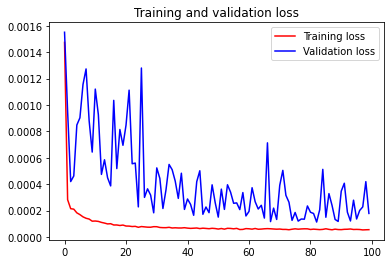

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

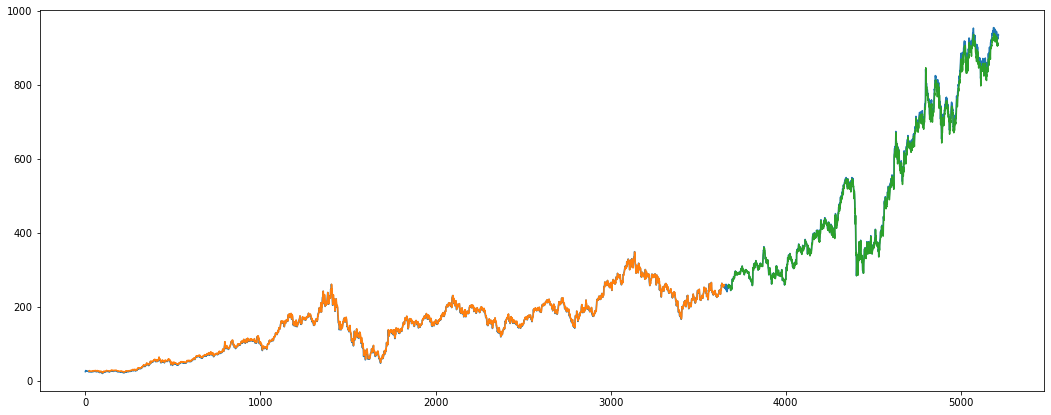

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.25227224, 0.2478932 , 0.25747844, ..., 0.96703063, 0.97125886,
       0.98051808])

In [49]:
test_predict

array([[256.5626 ],
       [255.80396],
       [251.56306],
       ...,
       [909.4679 ],
       [906.3589 ],
       [911.84204]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

1544

In [52]:
test_predict1

array([256.5626 , 255.80396, 251.56306, ..., 909.4679 , 906.3589 ,
       911.84204], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.25227224, 0.2478932 , 0.25747844, ..., 0.96703063, 0.97125886,
        0.98051808]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[255.77272034, 251.68182373, 260.63635254, ..., 923.5       ,
        927.45001221, 936.09997559]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

1544

In [64]:
df2 = df.iloc[3672:,:]

In [65]:
len(df2)

1544

In [66]:
df2.head()

,Open,Close
Date,,
2017-03-31,254.863632,251.681824
2017-04-03,253.454544,260.636353
2017-04-05,260.454559,258.954559
2017-04-06,256.272736,255.318176
2017-04-07,254.636368,252.136368


In [67]:
df2['predicted'] = test_predict1

In [68]:
df2.head(20)

,Open,Close,predicted
Date,,,
2017-03-31,254.863632,251.681824,256.562592
2017-04-03,253.454544,260.636353,255.803955
2017-04-05,260.454559,258.954559,251.563065
2017-04-06,256.272736,255.318176,260.413177
2017-04-07,254.636368,252.136368,259.287628
2017-04-10,253.090912,252.409088,255.308640
2017-04-11,253.000000,257.863647,252.124252
2017-04-12,258.000000,255.272720,252.593277
2017-04-13,254.818176,257.090912,258.214020


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1544 entries, 2017-03-31 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1544 non-null   float64
 1   Close      1544 non-null   float64
 2   predicted  1544 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 42.2 KB


In [70]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,924.400024,925.750000,909.956482
2023-06-23,926.049988,923.500000,908.483215
2023-06-26,927.099976,927.450012,909.467896
2023-06-27,930.000000,936.099976,906.358887
2023-06-30,940.500000,934.599976,911.842041


In [71]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [72]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2017-03-31,254.863632,251.681824,256.562592,4.880768
2017-04-03,253.454544,260.636353,255.803955,-4.832397
2017-04-05,260.454559,258.954559,251.563065,-7.391495
2017-04-06,256.272736,255.318176,260.413177,5.095001
2017-04-07,254.636368,252.136368,259.287628,7.151260


In [73]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [74]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2017-03-31,254.863632,251.681824,256.562592,4.880768,1
2017-04-03,253.454544,260.636353,255.803955,-4.832397,0
2017-04-05,260.454559,258.954559,251.563065,-7.391495,0
2017-04-06,256.272736,255.318176,260.413177,5.095001,1
2017-04-07,254.636368,252.136368,259.287628,7.151260,1


In [75]:
df2.drop(columns='temp_signal',inplace = True)

In [76]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2017-03-31,254.863632,251.681824,256.562592,1
2017-04-03,253.454544,260.636353,255.803955,0
2017-04-05,260.454559,258.954559,251.563065,0
2017-04-06,256.272736,255.318176,260.413177,1
2017-04-07,254.636368,252.136368,259.287628,1


In [77]:
signal = list(df2['signal'])

In [78]:
signal

[1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,


In [79]:
signal.insert(0,999)

In [80]:
signal

[999,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1

In [81]:
len(df2)

1544

In [82]:
len(signal)

1545

In [83]:
signal.pop()

0

In [84]:
len(signal)

1544

In [85]:
new_signal = np.array(signal)

In [86]:
new_signal

array([999,   1,   0, ...,   0,   0,   0])

In [87]:
df2['new_signal'] = new_signal

In [88]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2017-03-31,254.863632,251.681824,256.562592,1,999
2017-04-03,253.454544,260.636353,255.803955,0,1
2017-04-05,260.454559,258.954559,251.563065,0,0
2017-04-06,256.272736,255.318176,260.413177,1,0
2017-04-07,254.636368,252.136368,259.287628,1,1


In [89]:
df2.drop(columns = 'signal',inplace = True)

In [90]:
df3 = df2[df2['new_signal']==1]

In [91]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-04-03,253.454544,260.636353,255.803955,1
2017-04-07,254.636368,252.136368,259.287628,1
2017-04-10,253.090912,252.409088,255.308640,1
2017-04-11,253.000000,257.863647,252.124252,1
2017-04-17,257.272736,256.727264,255.751953,1


In [92]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [93]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-04-03,253.454544,260.636353,255.803955,1,7.181808
2017-04-07,254.636368,252.136368,259.287628,1,-2.500000
2017-04-10,253.090912,252.409088,255.308640,1,-0.681824
2017-04-11,253.000000,257.863647,252.124252,1,4.863647
2017-04-17,257.272736,256.727264,255.751953,1,-0.545471


In [94]:
df3['profit_loss'].sum()

162.47268676757812

In [95]:
df4 = df2[df2['new_signal']==0]

In [96]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [97]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-04-05,260.454559,258.954559,251.563065,0,1.500000
2017-04-06,256.272736,255.318176,260.413177,0,0.954559
2017-04-12,258.000000,255.272720,252.593277,0,2.727280
2017-04-13,254.818176,257.090912,258.214020,0,-2.272736
2017-04-18,257.636353,257.636353,257.130524,0,0.000000


In [98]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-03-31,254.863632,251.681824,256.562592,999
2017-04-03,253.454544,260.636353,255.803955,1
2017-04-05,260.454559,258.954559,251.563065,0
2017-04-06,256.272736,255.318176,260.413177,0
2017-04-07,254.636368,252.136368,259.287628,1


In [99]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,924.400024,925.750000,909.956482,0
2023-06-23,926.049988,923.500000,908.483215,0
2023-06-26,927.099976,927.450012,909.467896,0
2023-06-27,930.000000,936.099976,906.358887,0
2023-06-30,940.500000,934.599976,911.842041,0


In [100]:
df4['profit_loss'].sum()

252.135986328125

In [101]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [102]:
Total_profit

414.6086730957031

In [103]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  254.86363220214844
Ending price:  911.842041015625


In [104]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

656.9784088134766

In [105]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

-242.36973571777344

In [106]:
len(df3)

531

In [107]:
len(df4)

1012

In [108]:
len(df2)

1544